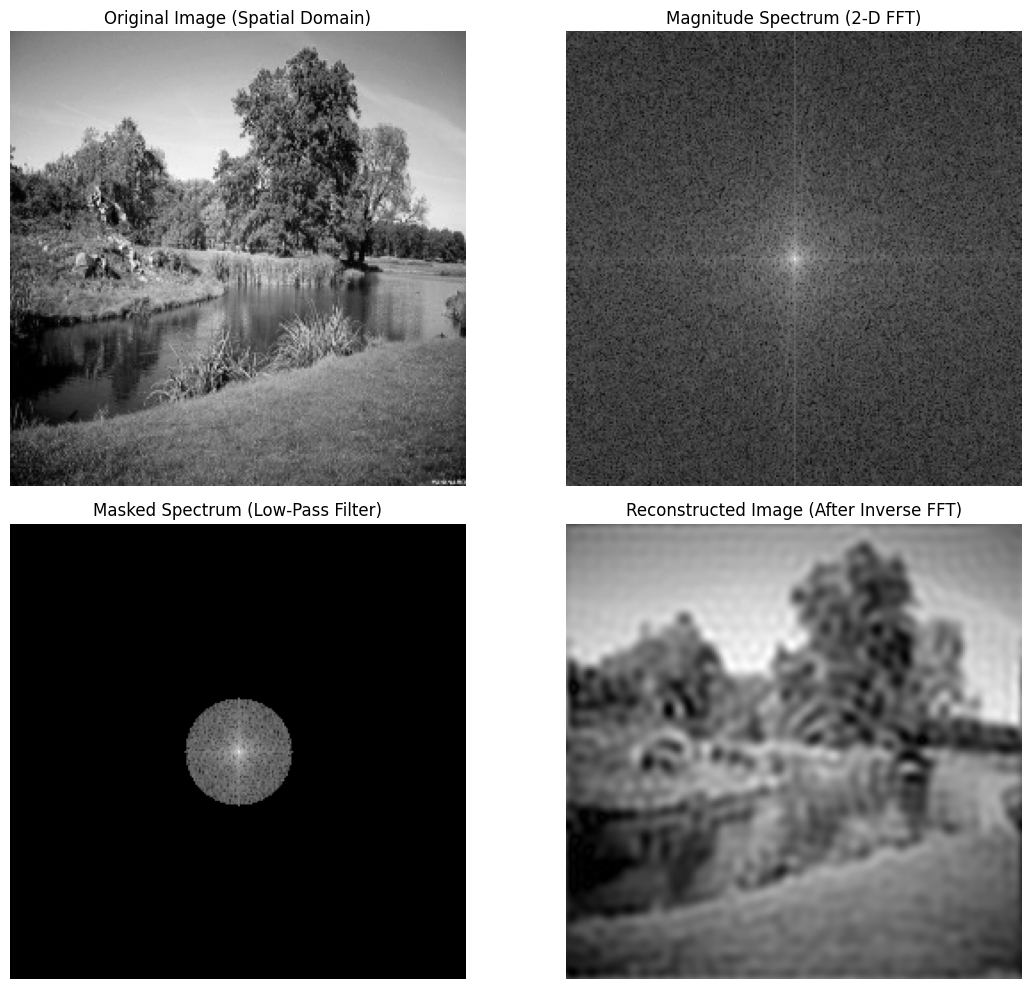

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def load_and_preprocess_image(path, size=(256, 256)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise FileNotFoundError("Image not found. Check file path.")

    img = cv2.resize(img, size)
    img = img.astype(np.float32) / 255.0
    return img

def create_circular_mask(h, w, radius):
    center = (w // 2, h // 2)
    Y, X = np.ogrid[:h, :w]
    distance = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = distance <= radius
    return tf.cast(mask, tf.complex64)

image_path = '/content/test_image.jpg'
image = load_and_preprocess_image(image_path)

image_tensor = tf.convert_to_tensor(image, dtype=tf.complex64)

fft_image = tf.signal.fft2d(image_tensor)
fft_shifted = tf.signal.fftshift(fft_image)

magnitude_spectrum = tf.math.log(1 + tf.abs(fft_shifted))

rows, cols = image.shape
lp_mask = create_circular_mask(rows, cols, radius=30)

filtered_fft = fft_shifted * lp_mask
masked_spectrum = tf.math.log(1 + tf.abs(filtered_fft))

ifft_shifted = tf.signal.ifftshift(filtered_fft)
reconstructed = tf.signal.ifft2d(ifft_shifted)
reconstructed = tf.abs(reconstructed)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image (Spatial Domain)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum (2-D FFT)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(masked_spectrum, cmap='gray')
plt.title('Masked Spectrum (Low-Pass Filter)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(reconstructed, cmap='gray')
plt.title('Reconstructed Image (After Inverse FFT)')
plt.axis('off')

plt.tight_layout()
plt.show()